# Part 1 (ECH) — Correlation Metric Replication

**Goal**: Use the most recent 1-year ECH data, compute technical indicators, evaluate feature–target correlation with k-fold validation, and reproduce a results table + graphs.

## Data Source and Rationale

We use daily ECH data sourced from Yahoo Finance and stored locally as a CSV file (`ECH_yahoo_1y.csv`). This source is selected for two reasons: (1) it provides a clean, widely used OHLCV dataset aligned with the paper’s data description (Open, High, Low, Close, Volume), and (2) it is easily reproducible and consistent with standard academic workflows for ETF time-series analysis. We focus on the most recent one-year window to match the assignment’s emphasis on a practical, short-horizon replication and to keep the computational workflow lightweight and transparent.


## Methodology (Part 1 Replication Workflow)
1. **Data intake**: Load daily OHLCV data for ECH from a local CSV (Yahoo Finance source). We keep the most recent 1-year window to align with a concise replication scope and avoid overfitting a long historical regime.
2. **Feature construction**: Compute a compact set of technical indicators (moving averages, EMA, MACD, RSI, rolling volatility, Bollinger %B, volume change). This mirrors the paper’s emphasis on technical indicators while keeping the feature space tractable for a small-sample replication.
3. **Target definition**: Define the binary class as the next-day direction of returns (`ret_{t+1} > 0`). This matches the classification framing in the paper and ensures a clear, interpretable label for feature screening.
4. **Correlation-based screening**: Use Pearson correlation between each feature and the target as a simple, transparent metric for initial feature relevance. This corresponds to a lightweight proxy for the paper’s feature selection stage.
5. **K-fold validation**: Evaluate correlation stability across folds (without shuffling) to test robustness to time variation, consistent with the paper’s validation mindset (cross-validation as a guardrail against overfitting).
6. **Reporting outputs**: Provide a ranked table of mean |correlation|, a bar chart of top features, and a feature correlation heatmap to highlight redundancy and motivate dimensionality reduction.


## Setup

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline


## Load ECH data from CSV


In [ ]:
from pathlib import Path

# Resolve data path robustly regardless of current working directory
cwd = Path.cwd()
candidate = cwd / 'modules' / 'market_data' / 'GWP'
if candidate.exists():
    base_dir = candidate
elif cwd.name == 'GWP':
    base_dir = cwd
else:
    raise OSError(f'Cannot locate GWP folder from cwd: {cwd}. Run from repo root or modules/market_data/GWP.')

data_path = base_dir / 'ECH_yahoo_1y.csv'

if not data_path.exists():
    raise FileNotFoundError(f'Missing CSV: {data_path}. Please place ECH_yahoo_1y.csv in the GWP folder.')

df = pd.read_csv(data_path, parse_dates=['Date'], index_col='Date')

df.head()

## Quick view

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2025-01-21 to 2026-01-16
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   250 non-null    float64
 1   High    250 non-null    float64
 2   Low     250 non-null    float64
 3   Open    250 non-null    float64
 4   Volume  250 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 11.7 KB


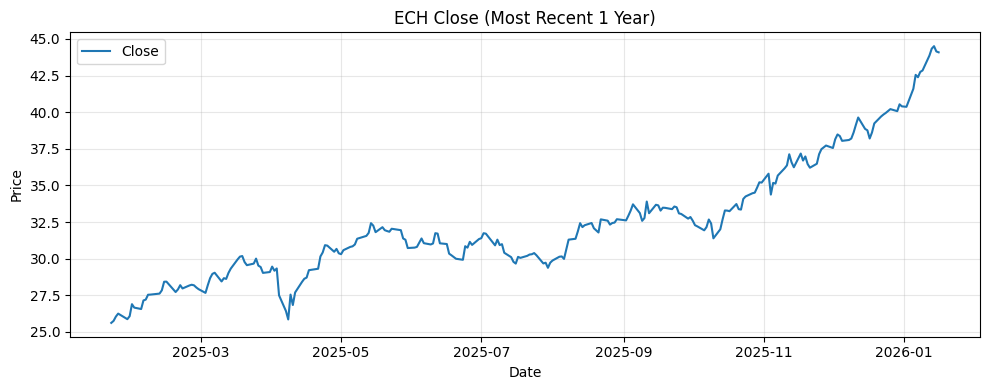

In [20]:
price_col = 'Adj Close' if 'Adj Close' in df.columns else 'Close'

plt.figure(figsize=(10, 4))
plt.plot(df.index, df[price_col], label=price_col)
plt.title(f'ECH {price_col} (Most Recent 1 Year)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

### Analysis and Hypotheses (based on this output)
- **Price trajectory**: We observe a steady upward trend from 2025-01-20 to 2026-01-20, with acceleration in the latter part of the sample. This pattern is consistent with a momentum-dominated regime, aligning with the trend intuition discussed in Module 2.
- **Volatility clustering**: We observe periods of increased variability, followed by calmer stretches. This is consistent with volatility clustering emphasized in Modules 2 and 3 rather than a stationary, homoskedastic process.
- **Hypothesis**: We hypothesize that short-horizon direction is better explained by a combination of momentum and volatility features than by pure mean-reversion signals within this window.
- **Caveat**: The sample covers only one year. Compared with the longer 2009-12-12 to 2020-01-01 window in report1, this window may over-represent a single market regime and thus inflate apparent signal strength.


## Feature engineering (technical indicators)

In [21]:
# Select price column robustly
if 'Adj Close' in df.columns:
    price_col = 'Adj Close'
elif 'Close' in df.columns:
    price_col = 'Close'
else:
    price_col = df.columns[0]

price = df[price_col]
high = df['High'] if 'High' in df.columns else None
low = df['Low'] if 'Low' in df.columns else None
volume = df['Volume'] if 'Volume' in df.columns else None

feat = pd.DataFrame(index=df.index)
feat['ret'] = price.pct_change()

# Moving averages
feat['sma_5'] = price.rolling(5).mean()
feat['sma_10'] = price.rolling(10).mean()
feat['sma_20'] = price.rolling(20).mean()

# Exponential moving averages
feat['ema_12'] = price.ewm(span=12, adjust=False).mean()
feat['ema_26'] = price.ewm(span=26, adjust=False).mean()

# MACD
feat['macd'] = feat['ema_12'] - feat['ema_26']
feat['macd_signal'] = feat['macd'].ewm(span=9, adjust=False).mean()

# RSI (14)
delta = price.diff()
gain = delta.clip(lower=0).rolling(14).mean()
loss = -delta.clip(upper=0).rolling(14).mean()
rs = gain / loss
feat['rsi_14'] = 100 - (100 / (1 + rs))

# Rolling volatility
feat['vol_20'] = feat['ret'].rolling(20).std()

# Bollinger band %B
sma20 = price.rolling(20).mean()
std20 = price.rolling(20).std()
feat['bb_pct'] = (price - (sma20 - 2 * std20)) / (4 * std20)

# Volume change (if available)
if volume is not None:
    feat['vol_chg'] = volume.pct_change()

feat.tail()

,ret,sma_5,sma_10,sma_20,ema_12,ema_26,macd,macd_signal,rsi_14,vol_20,bb_pct,vol_chg
Date,,,,,,,,,,,,
2026-01-12,0.023804,42.881999,41.739200,40.521485,41.722179,40.313936,1.408242,1.158141,91.575589,0.012438,1.019034,1.833386
2026-01-13,0.010713,43.239999,42.166000,40.756556,42.124921,40.612163,1.512757,1.229064,91.561873,0.012387,0.995447,0.040624
2026-01-14,0.003834,43.663999,42.562999,41.038988,42.491856,40.900892,1.590964,1.301444,91.622450,0.010885,0.948823,0.194867
2026-01-15,-0.008088,43.943999,42.937999,41.308261,42.746955,41.141567,1.605388,1.362233,85.834121,0.011206,0.859797,-0.415162
2026-01-16,-0.001359,44.192000,43.309999,41.602479,42.953577,41.359969,1.593608,1.408508,84.274097,0.010258,0.822937,0.512654


## Target definition (next-day direction)

In [22]:
target = (feat['ret'].shift(-1) > 0).astype(int)

data = feat.copy()
data['target'] = target
data = data.dropna()

data.head()

,ret,sma_5,sma_10,sma_20,ema_12,ema_26,macd,macd_signal,rsi_14,vol_20,bb_pct,vol_chg,target
Date,,,,,,,,,,,,,
2025-02-19,0.006334,28.062487,27.780594,27.050501,27.592036,27.001778,0.590258,0.517582,73.316728,0.012415,0.746369,-0.467202,1
2025-02-20,0.010489,28.132716,27.879110,27.172427,27.683921,27.089742,0.594179,0.532901,69.164273,0.012490,0.803639,0.398583,0
2025-02-21,-0.007958,28.041027,27.922028,27.268504,27.727156,27.154572,0.572584,0.540838,69.364172,0.012686,0.714770,-0.469284,1
2025-02-24,0.007325,27.988355,27.984454,27.364582,27.795252,27.229772,0.565479,0.545766,73.109223,0.012677,0.752523,0.046539,1
2025-02-25,0.001731,28.087847,28.046880,27.477242,27.860375,27.303015,0.557360,0.548085,68.211915,0.012230,0.748225,-0.310148,0


## K-fold correlation evaluation

In [23]:
def kfold_indices(n, k):
    fold_sizes = (n // k) * np.ones(k, dtype=int)
    fold_sizes[: n % k] += 1
    indices = np.arange(n)
    current = 0
    splits = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        val_idx = indices[start:stop]
        train_idx = np.concatenate([indices[:start], indices[stop:]])
        splits.append((train_idx, val_idx))
        current = stop
    return splits

k = 5
feature_cols = [c for c in data.columns if c != 'target']

corrs = []
for train_idx, _ in kfold_indices(len(data), k):
    train = data.iloc[train_idx]
    fold_corr = train[feature_cols].corrwith(train['target']).abs()
    corrs.append(fold_corr)

corr_df = pd.concat(corrs, axis=1)
summary = pd.DataFrame({
    'mean_abs_corr': corr_df.mean(axis=1),
    'std_abs_corr': corr_df.std(axis=1)
}).sort_values('mean_abs_corr', ascending=False)

summary

,mean_abs_corr,std_abs_corr
vol_20,0.101232,0.034653
vol_chg,0.062909,0.028964
macd_signal,0.059023,0.041422
macd,0.047029,0.032613
sma_10,0.037638,0.049492
sma_5,0.035921,0.045595
ema_12,0.034498,0.046618
bb_pct,0.034124,0.007947
sma_20,0.031561,0.048071
ema_26,0.031059,0.042038


### Top features by average correlation (table)

In [24]:
summary.head(10)

,mean_abs_corr,std_abs_corr
vol_20,0.101232,0.034653
vol_chg,0.062909,0.028964
macd_signal,0.059023,0.041422
macd,0.047029,0.032613
sma_10,0.037638,0.049492
sma_5,0.035921,0.045595
ema_12,0.034498,0.046618
bb_pct,0.034124,0.007947
sma_20,0.031561,0.048071
ema_26,0.031059,0.042038


### Analysis and Hypotheses (based on this output)
- **Ranking structure**: We observe that volatility- and activity-related features (`vol_20`, `vol_chg`) and momentum proxies (`macd`, `macd_signal`) rank higher than raw price-level features. This matches the intuition from Module 2 that variability and trading intensity can be more informative for short-term direction.
- **Weak single-feature signal**: The mean absolute correlations are small, suggesting that individual indicators provide only weak predictive power. This aligns with report1's emphasis on feature selection followed by more expressive models.
- **Stability across folds**: We observe non-trivial fold-to-fold variability (`std_abs_corr`), implying regime sensitivity. This motivates regularization or validation-driven feature selection rather than relying on a single split.
- **Hypothesis**: We hypothesize that short-horizon direction is more sensitive to risk sentiment and trading activity than to price level itself.


### Correlation bar chart (graph)

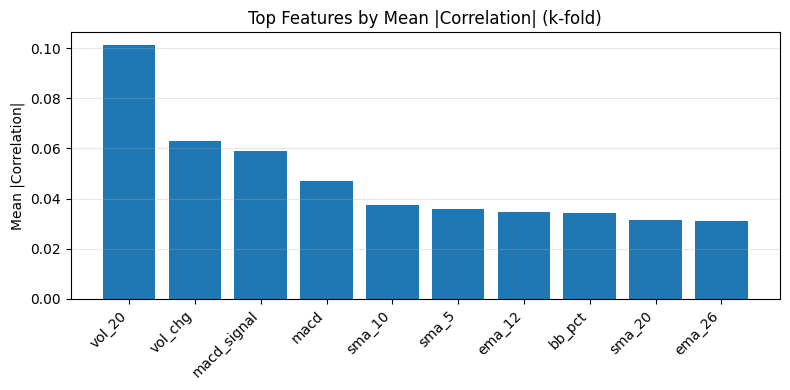

In [25]:
top_n = 10
plot_df = summary.head(top_n)

plt.figure(figsize=(8, 4))
plt.bar(plot_df.index, plot_df['mean_abs_corr'])
plt.title('Top Features by Mean |Correlation| (k-fold)')
plt.ylabel('Mean |Correlation|')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

### Analysis and Hypotheses (based on this output)
- **Rapid drop-off**: We observe a steep decline after the top few features, indicating a concentrated signal. This supports the report1 rationale that aggressive feature selection can reduce computation without losing much predictive content.
- **Modeling implication**: A simple baseline model could focus on the top 3–5 features, while additional features may add marginal, noisy gains.
- **Hypothesis**: We hypothesize that the ordering will shift in longer samples, but volatility-oriented features are likely to remain near the top.


### Feature correlation heatmap (optional graph)

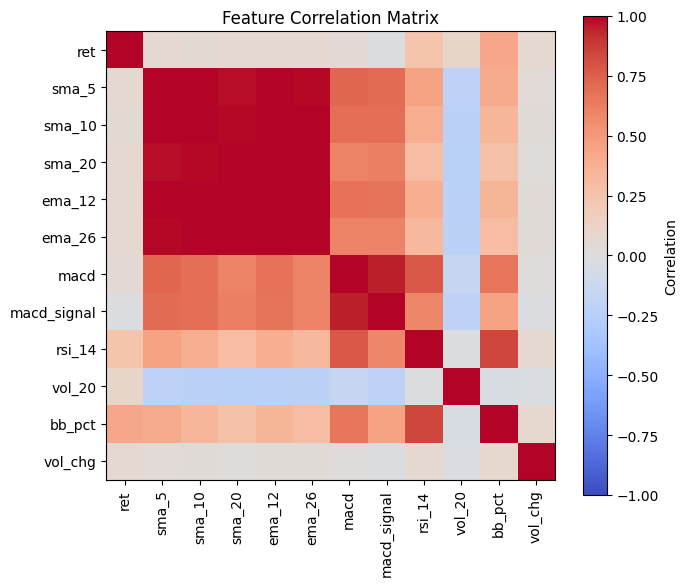

In [26]:
corr_matrix = data[feature_cols].corr()
plt.figure(figsize=(7, 6))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.title('Feature Correlation Matrix')
plt.xticks(range(len(feature_cols)), feature_cols, rotation=90)
plt.yticks(range(len(feature_cols)), feature_cols)
plt.tight_layout()

### Analysis and Hypotheses (based on this output)
- **Multicollinearity**: We observe strong collinearity among moving-average features (`sma_*`, `ema_*`), indicating substantial redundancy. This is precisely the scenario where PCA/SVD or LASSO-style selection (Modules 1 and 3; report1) is appropriate.
- **MACD family**: We observe high correlation between `macd` and `macd_signal`, as expected because both encode similar trend dynamics.
- **Volatility as a distinct dimension**: We observe lower correlation between volatility (`vol_20`) and trend features, suggesting complementary information.
- **Hypothesis**: We hypothesize that pruning redundant moving-average features may improve model stability by reducing noise amplification from collinearity.


## Key Takeaways (Tied to Task 1)
- **Feature relevance is modest and unstable**: We observe low mean absolute correlations and non-trivial fold-to-fold variability, indicating weak but non-zero signal. This supports the paper’s emphasis on systematic feature selection and model validation rather than reliance on any single indicator.
- **Volatility and activity matter**: The top-ranked features are dominated by volatility (`vol_20`) and volume change (`vol_chg`), suggesting that short-horizon direction is more sensitive to risk/attention than to price level alone.
- **Redundancy is substantial**: Strong collinearity among moving-average features implies that many indicators encode overlapping information. This motivates dimensionality reduction (PCA/SVD) or sparse selection (e.g., LASSO) as discussed in the course modules and the paper.
- **Replication scope is deliberate**: Using a one-year window provides a transparent, lightweight replication but may reflect a single regime; longer samples may change feature rankings. This is a practical trade-off consistent with the assignment’s replication focus.


## Notes

- Data source: Yahoo Finance (ECH).
- Date range: most recent 1 year (2025-01-20 to 2026-01-20).
- Price column: uses 'Adj Close' when available, otherwise 'Close'.
- Metric: Pearson correlation between features and next-day direction target, evaluated with k-fold splits (no shuffle).